In [1]:
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

import network
from preprocess_data import Game, PowerPlay, Situation, Venue, read_networks

In [2]:
def regular_networks():
    return read_networks(Situation.REGULAR)


def power_play_networks():
    return read_networks(Situation.POWER_PLAY)


def penalty_kill_networks():
    return read_networks(Situation.PENALTY_KILL)

In [3]:
def fit(df: pd.DataFrame, covariates: List[str], target: str, family: str = "binomial"):
    X = df[covariates]
    X = sm.add_constant(X)
    y = df[target]
    match family:
        case "binomial":
            model = sm.Logit(y, X)
        case "poisson":
            model = sm.GLM(y, X, family=sm.families.Poisson())
        case "gaussian":
            model = sm.OLS(y, X)
        case _:
            raise ValueError(f"{family} regression not implemented")
    res = model.fit()
    print(res.summary())

In [4]:
controls = {
    network.assortativity: ["log_n_passes"],
    network.clustering: ["log_n_passes"],
}

# Match Outcome Prediction

In [5]:
def get_win_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each game using the regular situations (no Power Play and Penalty Kill).

    Args:
        features (List[Callable] | Callable): features to be computed for each game

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, win, and features
    """
    if callable(features):
        features = [features]
    df = pd.DataFrame(
        [
            {"game_str": G.name, "n_passes": G.n_passes, "log_n_passes": np.log(G.n_passes), "win": G.win}
            | {feature.__name__: feature(G) for feature in features}
            for G in regular_networks()
        ]
    )
    return df

We don't look at connectivity and number of strongly connected components because our networks are fully connected. For the same reason we use *weighted* clustering in contrast to the Haka Network paper.

In [6]:
features = [
    network.assortativity,
    network.clustering,
    # network.degree_mean,
    # network.degree_std,
]
df = get_win_df(features)
df

,game_str,n_passes,log_n_passes,win,assortativity,clustering
0,2022-02-08 Canada at USA_reg_home,216.0,5.375278,0,0.120174,0.461392
1,2022-02-08 Canada at USA_reg_away,185.0,5.220356,1,-0.102773,0.474962
2,2022-02-08 ROC at Finland_reg_home,265.0,5.579730,1,0.041894,0.493256
3,2022-02-08 ROC at Finland_reg_away,200.0,5.298317,0,-0.120709,0.389216
4,2022-02-12 Switzerland at ROC_reg_home,266.0,5.583496,0,-0.026035,0.497432
5,2022-02-12 Switzerland at ROC_reg_away,212.0,5.356586,1,0.211820,0.476648
6,2022-02-14 Switzerland at Canada_reg_home,331.0,5.802118,1,0.028629,0.674079
7,2022-02-14 Switzerland at Canada_reg_away,147.0,4.990433,0,0.030374,0.296738
8,2022-02-14 USA at Finland_reg_home,239.0,5.476464,0,0.077702,0.432872
9,2022-02-14 USA at Finland_reg_away,220.0,5.393628,1,0.184663,0.563418


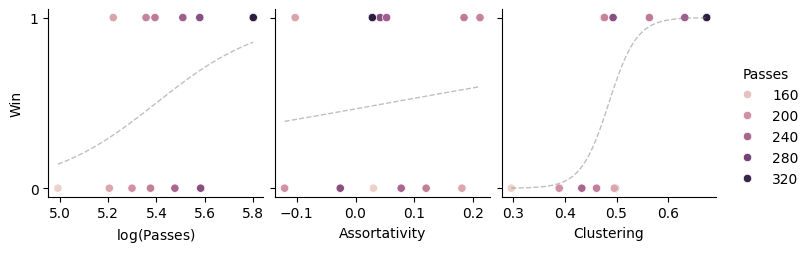

In [7]:
df = get_win_df(features)
xs = ["log_n_passes"] + [feature.__name__ for feature in features]
x_labels = {
    "log_n_passes": r"$\log(\text{Passes})$",
    "assortativity": "Assortativity",
    "clustering": "Clustering",
}

grid = sns.pairplot(
    df,
    x_vars=xs,
    y_vars=["win"],
    hue="n_passes",
)
for x, ax in zip(xs, grid.axes[0]):
    sns.regplot(
        x=x,
        y="win",
        data=df,
        logistic=True,
        ci=None,
        ax=ax,
        scatter=False,
        color="grey",
        line_kws={"lw": 1, "ls": "--", "alpha": 0.5},
    )
    ax.set_xlabel(x_labels[x])
    ax.set_ylabel("Win")
    plt.yticks([0, 1])

grid.legend.set_title("Passes")
plt.savefig("report/images/hockey/winner_scatter.png", dpi=600, bbox_inches="tight")

In [8]:
df = get_win_df(features)
fit(df, ["log_n_passes"], "win", "binomial")

Optimization terminated successfully.
         Current function value: 0.614040
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   12
Model:                          Logit   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.1141
Time:                        15:43:46   Log-Likelihood:                -7.3685
converged:                       True   LL-Null:                       -8.3178
Covariance Type:            nonrobust   LLR p-value:                    0.1682
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -23.8874     19.524     -1.223      0.221     -62.155      14.380
log_n_passes     4.4240

In [9]:
df = get_win_df(features)
fit(df, ["clustering"], "win", "binomial")

Optimization terminated successfully.
         Current function value: 0.394933
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   12
Model:                          Logit   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.4302
Time:                        15:43:47   Log-Likelihood:                -4.7392
converged:                       True   LL-Null:                       -8.3178
Covariance Type:            nonrobust   LLR p-value:                  0.007467
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.9745     13.762     -1.306      0.192     -44.948       8.999
clustering    37.0475     28.

In [10]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_win_df(feature)
    df.dropna(inplace=True)
    fit(df, covariates=[feature_name] + controls[feature], target="win", family="binomial")
    print("\n\n")

Feature: assortativity
Optimization terminated successfully.
         Current function value: 0.604426
         Iterations 6


                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   12
Model:                          Logit   Df Residuals:                        9
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.1280
Time:                        15:43:47   Log-Likelihood:                -7.2531
converged:                       True   LL-Null:                       -8.3178
Covariance Type:            nonrobust   LLR p-value:                    0.3448
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -24.5086     19.818     -1.237      0.216     -63.351      14.334
assortativity     2.8967      6.148      0.471      0.638      -9.153      14.946
log_n_passes      4.5043      3.656     

In [11]:
pearsonr(df["clustering"], df["log_n_passes"])

PearsonRResult(statistic=0.7604263492028684, pvalue=0.004089658069850316)

Conclusion: doesn't work (i.e. no significance). There are two possible explanations:
- We are using too little data
- The investigated features are not predictive

We have data from six games, giving twelve data points. Hence, it would not be surprising if that is not enough data.

# Goals Scored

In [12]:
def get_goals_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each game using the regular situations (no Power Play and Penalty Kill).

    Args:
        features (List[Callable] | Callable): features to be computed for each game

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, win, and features
    """
    if callable(features):
        features = [features]
    df = pd.DataFrame(
        [
            {
                "game_str": G.name,
                "n_passes": G.n_passes,
                "log_n_passes": np.log(G.n_passes),
                "win": G.win,
                "goals": G.home_score if G.venue == Venue.HOME else G.away_score,
            }
            | {feature.__name__: feature(G) for feature in features}
            for G in regular_networks()
        ]
    )
    return df

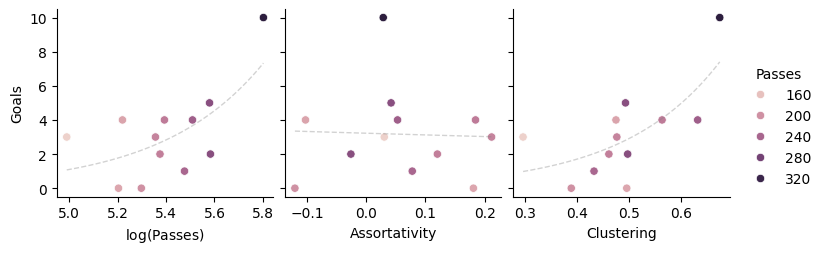

In [13]:
df = get_goals_df(features)
xs = ["log_n_passes"] + [feature.__name__ for feature in features]
x_labels = {"log_n_passes": r"$\log(\text{Passes})$", "assortativity": "Assortativity", "clustering": "Clustering"}

grid = sns.pairplot(
    df,
    x_vars=xs,
    y_vars=["goals"],
    hue="n_passes",
)
for x, ax in zip(xs, grid.axes[0]):
    lm = sm.GLM(df["goals"], sm.add_constant(df[x]), family=sm.families.Poisson()).fit()
    inputs = np.linspace(df[x].min(), df[x].max(), 100)
    sns.lineplot(
        x=inputs,
        y=lm.predict(sm.add_constant(inputs)),
        ax=ax,
        color="grey",
        **{"lw": 1, "ls": "--", "alpha": 0.35},
    )
    ax.legend().remove()
    ax.set_xlabel(x_labels[x])
    ax.set_ylabel("Goals")

grid.legend.set_title("Passes")
plt.savefig("report/images/hockey/goals_scatter.png", dpi=600, bbox_inches="tight")

In [14]:
fit(df, ["log_n_passes"], "goals", "poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24.256
Date:                Mon, 18 Dec 2023   Deviance:                       17.866
Time:                        15:43:52   Pearson chi2:                     14.8
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5147
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.7570      4.457     -2.638   

In [15]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_goals_df(feature)
    df.dropna(inplace=True)
    fit(df, covariates=[feature_name] + controls[feature], target="goals", family="poisson")
    print("\n\n")

Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                   12
Model:                            GLM   Df Residuals:                        9
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24.255
Date:                Mon, 18 Dec 2023   Deviance:                       17.864
Time:                        15:43:52   Pearson chi2:                     14.9
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5148
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -11.789

# Power Play Success Prediction (Goal or nah)

In [16]:
def game_and_venue(G) -> Tuple[Game, Venue]:
    return (G.game.game, G.venue)


def get_pp_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each Power Play for regressing on the success of the Power Play (goal or not) or
    the number of shots.

    Args:
        features (List[Callable] | Callable): features to be computed for each PP

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, target, normal_feature_1, ..., normal_feature_n, pp_feature_1, ..., pp_feature_n
    """
    if callable(features):
        features = [features]
    regular_feature_map = {game_and_venue(G): {feature: feature(G) for feature in features} for G in regular_networks()}
    df = pd.DataFrame(
        [
            {
                "game_str": G.name,
                "n_passes": G.n_passes,
                "log_n_passes": np.log(G.n_passes),
                "goal": G.goal,
                "n_shots": G.n_shots,
            }
            | {f"normal_{feature.__name__}": regular_feature_map[game_and_venue(G)][feature] for feature in features}
            | {f"pp_{feature.__name__}": feature(G) for feature in features}
            for G in power_play_networks()
        ]
    )
    for feature in features:
        df[f"{feature.__name__}_diff"] = df[f"normal_{feature.__name__}"] - df[f"pp_{feature.__name__}"]

    return df

In [17]:
get_pp_df(features).head(7)

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


,game_str,n_passes,log_n_passes,goal,n_shots,normal_assortativity,normal_clustering,pp_assortativity,pp_clustering,assortativity_diff,clustering_diff
0,2022-02-08 Canada at USA_2_pp_home,27.0,3.295837,0,4,0.120174,0.461392,-0.441123,0.221375,0.561296,0.240017
1,2022-02-08 Canada at USA_3_pp_home,21.0,3.044522,0,4,0.120174,0.461392,-0.098857,0.291941,0.219031,0.169451
2,2022-02-08 Canada at USA_4_pp_home,15.0,2.708050,1,3,0.120174,0.461392,-0.828079,0.220036,0.948252,0.241356
3,2022-02-08 Canada at USA_5_pp_home,11.0,2.397895,0,2,0.120174,0.461392,0.683130,0.111614,-0.562957,0.349778
4,2022-02-08 Canada at USA_6_pp_home,34.0,3.526361,0,6,0.120174,0.461392,-0.282587,0.349990,0.402761,0.111402
5,2022-02-08 Canada at USA_1_pp_away,12.0,2.484907,1,1,-0.102773,0.474962,-0.250000,0.567420,0.147227,-0.092458
6,2022-02-08 ROC at Finland_4_pp_home,10.0,2.302585,1,2,0.041894,0.493256,0.213201,0.000000,-0.171307,0.493256


/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


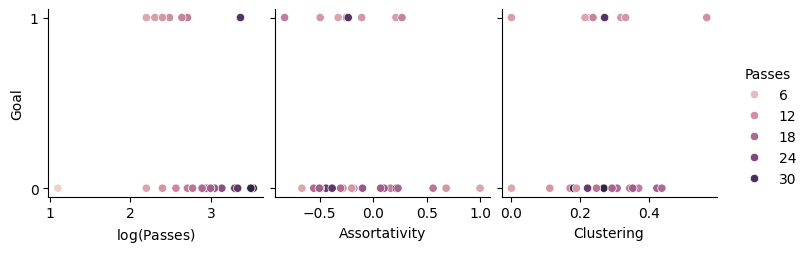

In [18]:
df = get_pp_df(features)
grid = sns.pairplot(
    df, hue="n_passes", x_vars=["log_n_passes"] + [f"pp_{feature.__name__}" for feature in features], y_vars=["goal"]
)
grid.axes[0][0].set_xlabel(r"$\log(\text{Passes})$")
grid.axes[0][0].set_ylabel("Goal")
grid.axes[0][1].set_xlabel("Assortativity")
grid.axes[0][2].set_xlabel("Clustering")
grid.legend.set_title("Passes")

plt.yticks([0, 1])
plt.savefig("report/images/hockey/pp_goal_scatter.png", dpi=600, bbox_inches="tight")

In [19]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="goal", family="binomial")
    print("\n\n")

Feature: assortativity
Optimization terminated successfully.
         Current function value: 0.473709
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.1831
Time:                        15:43:56   Log-Likelihood:                -14.211
converged:                       True   LL-Null:                       -17.397
Covariance Type:            nonrobust   LLR p-value:                   0.04133
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.7724      3.764      1.799      0.072      -0.606 

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


Optimization terminated successfully.
         Current function value: 0.527469
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                   31
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                 0.07627
Time:                        15:43:56   Log-Likelihood:                -16.352
converged:                       True   LL-Null:                       -17.702
Covariance Type:            nonrobust   LLR p-value:                    0.2592
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2411      2.412      0.929      0.353      -2.487       6.969
pp_clustering     3.

Also doesn't work.

# Predicting Number of Shots

Let's first see if `n_passes` predicts `n_shots`.

In [20]:
df = get_pp_df(features)
fit(df, covariates=["n_passes"], target="n_shots", family="poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       29
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.081
Date:                Mon, 18 Dec 2023   Deviance:                       35.234
Time:                        15:43:57   Pearson chi2:                     36.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4820
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.283      0.035      0.9

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


It does. The number of passes is a significant predictor of the number of shots (p<0.0005). The coefficient is 0.0563, which means that all else equal, for every additional pass, we expect an increase in the number of shots by a factor of $e^{0.0563}\approx 1.057$ (remember that we use Poisson regression).

Let's see if the other network features are also predictive of the number of shots.

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


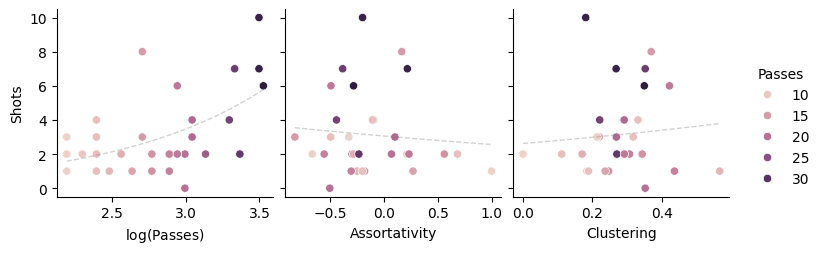

In [21]:
df = get_pp_df(features).dropna()
xs = ["log_n_passes"] + [f"pp_{feature.__name__}" for feature in features]
x_labels = {
    "log_n_passes": r"$\log(\text{Passes})$",
    "pp_assortativity": "Assortativity",
    "pp_clustering": "Clustering",
}

grid = sns.pairplot(
    df,
    x_vars=xs,
    y_vars=["n_shots"],
    hue="n_passes",
)
for x, ax in zip(xs, grid.axes[0]):
    lm = sm.GLM(df["n_shots"], sm.add_constant(df[x]), family=sm.families.Poisson()).fit()
    inputs = np.linspace(df[x].min(), df[x].max(), 100)
    sns.lineplot(
        x=inputs,
        y=lm.predict(sm.add_constant(inputs)),
        ax=ax,
        color="grey",
        **{"lw": 1, "ls": "--", "alpha": 0.35},
    )
    ax.legend().remove()
    ax.set_xlabel(x_labels[x])
    ax.set_ylabel("Shots")
    # plt.yticks([0, 1])

grid.legend.set_title("Passes")
plt.savefig("report/images/hockey/pp_shots_scatter.png", dpi=600, bbox_inches="tight")

In [22]:
df = get_pp_df(features)
fit(df, covariates=["pp_clustering"], target="n_shots", family="poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       29
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68.334
Date:                Mon, 18 Dec 2023   Deviance:                       53.742
Time:                        15:44:01   Pearson chi2:                     57.1
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05892
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7939      0.260      3.055

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [23]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="n_shots", family="poisson")
    print("\n\n")

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58.978
Date:                Mon, 18 Dec 2023   Deviance:                       35.029
Time:                        15:44:01   Pearson chi2:                     35.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3819
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            

`assortativity` and `clustering` are also not predictive in this task.

### Contrasting PP and Regular Play

We can also include the features from regular play (not power play) and see if the features become more predictive by being able to look at the contrast between normal play and power play.

In [24]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"{feature_name}_diff"] + controls[feature]
    fit(df, covariates=covariates, target="n_shots", family="poisson")
    print("\n\n")

Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58.938
Date:                Mon, 18 Dec 2023   Deviance:                       34.950
Time:                        15:44:01   Pearson chi2:                     35.1
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3835
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.320
Date:                Mon, 18 Dec 2023   Deviance:                       35.713
Time:                        15:44:01   Pearson chi2:                     37.1
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4739
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.9340      0.741     